In [ ]:
#how data are represented at each level (forward, backward, forward with padding on top) needs a little
    #experimentation to determine the best representation
    #also, is encoding at each layer really the best way? or just feeding the raw through?
    
#Outside web ips are going to be a problem/messy/noisy. Start by categorizing all outside ips by <OUTSIDE_IP>
    #instead of the ip address, or another 4 digit symbol to insert into the hex string.
    
#to help the models generalize more, for a given source ip address with probability p (say p = 0.1) 
    #use the token <OTHER_MACHINE>
    
#should we remove random parts of the header, i.e. checksum

#should I take out bias for RNNs?

#for the decoder,does the fork encoding need to happen ?
    #do we simply cat the hContext with the next words?
    
#Should the architecture just be encode, context and then prediction???

#Input data, should it have character and hex pair encoding as well?

In [2]:
%matplotlib inline

import os
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=gpu'#,optimizer=fast_compile'

import time
import os
import json
import subprocess
import cPickle
import sys
import binascii
import multiprocessing as mp
from itertools import chain
from collections import OrderedDict
import logging
#import ipaddress

import numpy as np
import random
from copy import copy

import blocks
from blocks.bricks import Linear, Softmax, Softplus, NDimensionalSoftmax, BatchNormalizedMLP,\
                          Rectifier, Logistic, Tanh, MLP
from blocks.bricks.recurrent import GatedRecurrent, Fork, LSTM
from blocks.initialization import Constant, IsotropicGaussian, Identity, Uniform
from blocks.bricks.cost import BinaryCrossEntropy, CategoricalCrossEntropy
from blocks.filter import VariableFilter
from blocks.roles import PARAMETER
from blocks.graph import ComputationGraph

import theano
from theano import tensor as T


module_logger = logging.getLogger(__name__)
sys.setrecursionlimit(100000)


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, CuDNN 4007)


In [ ]:
import datetime
import time
ts = time.time()
timestamp = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

# Data

In [3]:
#start = time.time()
dataPath = '/data/fs4/datasets/pcaps/smallFlows.pcap'
#pcaps = rdpcap(dataPath)
#sessionPrep = pcaps.sessions()
#end = time.time()
#print end - start

In [4]:
def parse_header(line):  # pragma: no cover
    ret_dict = {}
    h = line.split()
    if h[2] == 'IP6':
        """
        Conditional formatting based on ethernet type.
        IPv4 format: 0.0.0.0.port
        IPv6 format (one of many): 0:0:0:0:0:0.port
        """
        ret_dict['src_port'] = h[3].split('.')[-1]
        ret_dict['src_ip'] = h[3].split('.')[0]
        ret_dict['dest_port'] = h[5].split('.')[-1].split(':')[0]
        ret_dict['dest_ip'] = h[5].split('.')[0]
    else:
        if len(h[3].split('.')) > 4:
            ret_dict['src_port'] = h[3].split('.')[-1]
            ret_dict['src_ip'] = '.'.join(h[3].split('.')[:-1])
        else:
            ret_dict['src_ip'] = h[3]
            ret_dict['src_port'] = ''
        if len(h[5].split('.')) > 4:
            ret_dict['dest_port'] = h[5].split('.')[-1].split(':')[0]
            ret_dict['dest_ip'] = '.'.join(h[5].split('.')[:-1])
        else:
            ret_dict['dest_ip'] = h[5].split(':')[0]
            ret_dict['dest_port'] = ''
    return ret_dict


def parse_data(line):  # pragma: no cover
    ret_str = ''
    h, d = line.split(':', 1)
    ret_str = d.strip().replace(' ', '')
    return ret_str


def process_packet(output):  # pragma: no cover
    # TODO!! throws away the first packet!
    ret_header = {}
    ret_dict = {}
    ret_data = ''
    hasHeader = False
    for line in output:
        line = line.strip()
        if line:
            if not line.startswith('0x'):
                # header line
                if ret_dict and ret_data:
                    # about to start new header, finished with hex
                    ret_dict['data'] = ret_data
                    yield ret_dict
                    ret_dict.clear()
                    ret_header.clear()
                    ret_data = ''
                    hasHeader = False

                # parse next header
                try:
                    ret_header = parse_header(line)
                    ret_dict.update(ret_header)
                    hasHeader = True
                except:
                    ret_header.clear()
                    ret_dict.clear()
                    ret_data = ''
                    hasHeader = False

            else:
                # hex data line
                if hasHeader:
                    data = parse_data(line)
                    ret_data = ret_data + data
                else:
                    continue


def is_clean_packet(packet):  # pragma: no cover
    """
    Returns whether or not the parsed packet is valid
    or not. Checks that both the src and dest
    ports are integers. Checks that src and dest IPs
    are valid address formats. Checks that packet data
    is hex. Returns True if all tests pass, False otherwise.
    """
    if not packet['src_port'].isdigit(): return False
    if not packet['dest_port'].isdigit(): return False

    if packet['src_ip'].isalpha(): return False
    if packet['dest_ip'].isalpha(): return False

    if 'data' in packet:
        try:
            int(packet['data'], 16)
        except:
            return False

    return True


def order_keys(hexSessionDict):
    """
    Returns list of the hex sessions in (rough) time order.
    """
    orderedKeys = []

    for key in sorted(hexSessionDict.keys(), key=lambda key: hexSessionDict[key][1]):
        orderedKeys.append(key)

    return orderedKeys


def read_pcap(path):  # pragma: no cover
    print 'starting reading pcap file'
    hex_sessions = {} 
    proc = subprocess.Popen('tcpdump -nn -tttt -xx -r '+path,
                            shell=True,
                            stdout=subprocess.PIPE)
    insert_num = 0  # keeps track of insertion order into dict
    for packet in process_packet(proc.stdout):
        if not is_clean_packet(packet):
            continue
        if 'data' in packet:
            key = (packet['src_ip']+":"+packet['src_port'], packet['dest_ip']+":"+packet['dest_port'])
            rev_key = (key[1], key[0])
            if key in hex_sessions:
                hex_sessions[key][0].append(packet['data'])
            elif rev_key in hex_sessions:
                hex_sessions[rev_key][0].append(packet['data'])
            else:
                hex_sessions[key] = ([packet['data']], insert_num)
                insert_num += 1

    print 'finished reading pcap file'
    return hex_sessions

In [5]:
def pickleFile(thing2save, file2save2=None, filePath='/work/notebooks/drawModels/', fileName='myModels'):  # pragma: no cover

    if file2save2 is None:
        f = file(filePath+fileName+'.pickle', 'wb')
    else:
        f = file(filePath+file2save2, 'wb')

    cPickle.dump(thing2save, f, protocol=cPickle.HIGHEST_PROTOCOL)
    f.close()


def loadFile(filePath):  # pragma: no cover
    file2open = file(filePath, 'rb')
    loadedFile = cPickle.load(file2open)
    file2open.close()
    return loadedFile


def removeBadSessionizer(hexSessionDict, saveFile=False, dataPath=None, fileName=None):  # pragma: no cover
    for ses in hexSessionDict.keys():
        paclens = []
        for pac in hexSessionDict[ses][0]:
            paclens.append(len(pac))
        if np.min(paclens)<80:
            del hexSessionDict[ses]

    if saveFile:
        print 'pickling sessions'
        pickleFile(hexSessionDict, filePath=dataPath, fileName=fileName)

    return hexSessionDict


# Making the hex dictionary
def hexTokenizer():  # pragma: no cover
    hexstring = '''0, 1, 2, 3, 4, 5, 6, 7, 8, 9, A, B, C, D, E, F,
                   10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1A, 1B,
                   1C, 1D, 1E, 1F, 20, 21, 22, 23, 24, 25, 26, 27,
                   28, 29, 2A, 2B, 2C, 2D, 2E, 2F, 30, 31, 32, 33,
                   34, 35, 36, 37, 38, 39, 3A, 3B, 3C, 3D, 3E, 3F,
                   40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 4A, 4B,
                   4C, 4D, 4E, 4F, 50, 51, 52, 53, 54, 55, 56, 57,
                   58, 59, 5A, 5B, 5C, 5D, 5E, 5F, 60, 61, 62, 63,
                   64, 65, 66, 67, 68, 69, 6A, 6B, 6C, 6D, 6E, 6F,
                   70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 7A, 7B,
                   7C, 7D, 7E, 7F, 80, 81, 82, 83, 84, 85, 86, 87,
                   88, 89, 8A, 8B, 8C, 8D, 8E, 8F, 90, 91, 92, 93,
                   94, 95, 96, 97, 98, 99, 9A, 9B, 9C, 9D, 9E, 9F,
                   A0, A1, A2, A3, A4, A5, A6, A7, A8, A9, AA, AB,
                   AC, AD, AE, AF, B0, B1, B2, B3, B4, B5, B6, B7,
                   B8, B9, BA, BB, BC, BD, BE, BF, C0, C1, C2, C3,
                   C4, C5, C6, C7, C8, C9, CA, CB, CC, CD, CE, CF,
                   D0, D1, D2, D3, D4, D5, D6, D7, D8, D9, DA, DB,
                   DC, DD, DE, DF, E0, E1, E2, E3, E4, E5, E6, E7,
                   E8, E9, EA, EB, EC, ED, EE, EF, F0, F1, F2, F3,
                   F4, F5, F6, F7, F8, F9, FA, FB, FC, FD, FE, FF'''.replace('\t', '')

    hexList = [x.strip() for x in hexstring.lower().split(',')]
    hexList.append('<EOP>')  # End Of Packet token
    hexDict = {}

    for key, val in enumerate(hexList):
        if len(val) == 1:
            val = '0'+val
        hexDict[val] = key  #dictionary k=hex, v=int  

    return hexDict

In [6]:
hexSessions = read_pcap(dataPath)
hexSessions = removeBadSessionizer(hexSessions)
hexSessionsKeys = order_keys(hexSessions)
hexDict = hexTokenizer()

starting reading pcap file
finished reading pcap file


# Dictionary of IP communications

In [7]:
def oneHot(index, granular = 'hex'):
    if granular == 'hex':
        vecLen = 257
    else:
        vecLen = 17
    
    zeroVec = np.zeros(vecLen)
    zeroVec[index] = 1.0
    
    return zeroVec
 

In [8]:

def oneSessionEncoder(sessionPackets, hexDict, maxPackets=2, packetTimeSteps=100,
                      packetReverse=False, charLevel=False, padOldTimeSteps=True):  # pragma: no cover
    
    sessionCollect = []
    packetCollect = []
    
    if charLevel:
        vecLen = 17
    else:
        vecLen = 257
    
    if len(sessionPackets) > maxPackets: #crop the number of sessions to maxPackets
        sessionList = copy(sessionPackets[:maxPackets])
    else:
        sessionList = copy(sessionPackets)

    for packet in sessionList:
        packet = packet[32:36]+packet[44:46]+packet[46:48]+packet[52:60]+packet[60:68]+\
                 packet[68:70]+packet[70:72]+packet[72:74]
        packet = [hexDict[packet[i:i+2]] for i in xrange(0,len(packet)-2+1,2)]
            
        if len(packet) >= packetTimeSteps: #crop packet to length packetTimeSteps
            packet = packet[:packetTimeSteps]
            packet = packet+[256] #add <EOP> end of packet token
        else:
            packet = packet+[256] #add <EOP> end of packet token
        
        packetCollect.append(packet)
        
        pacMat = np.array([oneHot(x) for x in packet]) #one hot encoding of packet into a matrix
        pacMatLen = len(pacMat)
        
        #padding packet
        if packetReverse:
            pacMat = pacMat[::-1]

        if pacMatLen < packetTimeSteps:
            #pad by stacking zeros on top of data so that earlier timesteps do not have information
            #padding the packet such that zeros are after the actual info for better translation
            if padOldTimeSteps:
                pacMat = np.vstack( ( np.zeros((packetTimeSteps-pacMatLen,vecLen)), pacMat) ) 
            else:
                pacMat = np.vstack( (pacMat, np.zeros((packetTimeSteps-pacMatLen,vecLen))) ) 

        if pacMatLen > packetTimeSteps:
            pacMat = pacMat[:packetTimeSteps, :]

        sessionCollect.append(pacMat)

    #padding session
    sessionCollect = np.asarray(sessionCollect, dtype=theano.config.floatX)
    numPacketsInSession = sessionCollect.shape[0]
    if numPacketsInSession < maxPackets:
        #pad sessions to fit the
        sessionCollect = np.vstack( (sessionCollect,np.zeros((maxPackets-numPacketsInSession,
                                                             packetTimeSteps, vecLen))) )
    
    return sessionCollect, packetCollect

# Learning functions

In [9]:
def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def dropout(X, p=0.):
    if p != 0:
        retain_prob = 1 - p
        X = X / retain_prob * srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
    return X

# Gradient clipping
def clip_norm(g, c, n): 
    '''n is the norm, c is the threashold, and g is the gradient'''
    
    if c > 0: 
        g = T.switch(T.ge(n, c), g*c/n, g) 
    return g

def clip_norms(gs, c):
    norm = T.sqrt(sum([T.sum(g**2) for g in gs]))
    return [clip_norm(g, c, norm) for g in gs]

# Regularizers
def max_norm(p, maxnorm = 0.):
    if maxnorm > 0:
        norms = T.sqrt(T.sum(T.sqr(p), axis=0))
        desired = T.clip(norms, 0, maxnorm)
        p = p * (desired/ (1e-7 + norms))
    return p

def gradient_regularize(p, g, l1 = 0., l2 = 0.):
    g += p * l2
    g += T.sgn(p) * l1
    return g

def weight_regularize(p, maxnorm = 0.):
    p = max_norm(p, maxnorm)
    return p

def Adam(params, cost, lr=0.0002, b1=0.1, b2=0.001, e=1e-8, l1 = 0., l2 = 0., maxnorm = 0., c = 8):
    
    updates = []
    grads = T.grad(cost, params)
    grads = clip_norms(grads, c)
    
    i = theano.shared(floatX(0.))
    i_t = i + 1.
    fix1 = 1. - b1**(i_t)
    fix2 = 1. - b2**(i_t)
    lr_t = lr * (T.sqrt(fix2) / fix1)
    
    for p, g in zip(params, grads):
        m = theano.shared(p.get_value() * 0.)
        v = theano.shared(p.get_value() * 0.)
        m_t = (b1 * g) + ((1. - b1) * m)
        v_t = (b2 * T.sqr(g)) + ((1. - b2) * v)
        g_t = m_t / (T.sqrt(v_t) + e)
        g_t = gradient_regularize(p, g_t, l1=l1, l2=l2)
        p_t = p - (lr_t * g_t)
        p_t = weight_regularize(p_t, maxnorm=maxnorm)
        
        updates.append((m, m_t))
        updates.append((v, v_t))
        updates.append((p, p_t))
    
    updates.append((i, i_t))
    #if iteration%100 == 0:
    #    updates.append((lr, lr*0.93))
    #else:
    #    updates.append((lr, lr))
    
    return updates

def RMSprop(cost, params, lr = 0.001, l1 = 0., l2 = 0., maxnorm = 0., rho=0.9, epsilon=1e-6, c = 8):
    
    grads = T.grad(cost, params)
    grads = clip_norms(grads, c)
    updates = []
    
    for p, g in zip(params, grads):
        g = gradient_regularize(p, g, l1 = l1, l2 = l2)
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        updates.append((acc, acc_new))
        
        updated_p = p - lr * (g / T.sqrt(acc_new + epsilon))
        updated_p = weight_regularize(updated_p, maxnorm = maxnorm)
        updates.append((p, updated_p))
    return updates

# Unsupervised feature extractor

### Initialization for both the unsupervised net and the classifier

In [48]:
X = T.tensor4('inputs', dtype=theano.config.floatX)
Y = T.matrix('targets')

wtstd = 0.2
dimIn = 257 #hex has 256 characters + the <EOP> character
dim = 100 #dimension reduction size
rnnType = 'gru' #gru or lstm
bidirectional = False
linewt_init = IsotropicGaussian(wtstd)
line_bias = Constant(1.0)
rnnwt_init = IsotropicGaussian(wtstd)
rnnbias_init = Constant(0.0)
packetReverse = False

###ENCODER
if rnnType == 'gru':
    rnn = GatedRecurrent(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, name = 'gru')
    dimMultiplier = 2
else:
    rnn = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, name = 'lstm')
    dimMultiplier = 4

fork = Fork(output_names=['linear', 'gates'],
            name='fork', input_dim=dimIn, output_dims=[dim, dim * dimMultiplier], 
            weights_init = linewt_init, biases_init = line_bias)


###CONTEXT
if rnnType == 'gru':
    rnnContext = GatedRecurrent(dim=dim, weights_init = rnnwt_init, 
                                biases_init = rnnbias_init, name = 'gruContext')
else:
    rnnContext = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, 
                      name = 'lstmContext')

forkContext = Fork(output_names=['linearContext', 'gatesContext'],
            name='forkContext', input_dim=dim, output_dims=[dim, dim * dimMultiplier], 
            weights_init = linewt_init, biases_init = line_bias)

if bidirectional:
    dimDec = dim*2
    
    if rnnType == 'gru':
        rnnContextRev = GatedRecurrent(dim=dim, weights_init = rnnwt_init, 
                                       biases_init = rnnbias_init, name = 'gruContextRev')
        
    else:
        rnnContextRev = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init,
                             name = 'lstmContextRev')
    
    rnnContextRev.initialize()

else:
    dimDec = dim


###DECODER
if rnnType == 'gru':
    rnnDec = GatedRecurrent(dim=dimIn, weights_init = rnnwt_init, 
                            biases_init = rnnbias_init, name = 'gruDecoder')
else:
    rnnDec = LSTM(dim=dimIn, weights_init = rnnwt_init, biases_init = rnnbias_init, name = 'lstmDecoder')


forkDec = Fork(output_names=['declinear', 'decgates'],
            name='forkDec', input_dim=dimDec, output_dims=[dim, dimIn*dimMultiplier], 
            weights_init = linewt_init, biases_init = line_bias)

forkFinal = Fork(output_names=['finallinear', 'finalgates'],
            name='forkFinal', input_dim=dim, output_dims=[dimIn, dimIn*dimMultiplier], 
            weights_init = linewt_init, biases_init = line_bias)

#initialize the weights in all the functions
fork.initialize()
rnn.initialize()

forkContext.initialize()
rnnContext.initialize()
forkDec.initialize()

forkFinal.initialize()
rnnDec.initialize()

### Unsupervised graph

ctxtest = theano.function([X], [data1, hContext], allow_input_downcast=True)

testones = np.ones((12,16,1,257))
testones[0] = testones[0]+3
testones[-1] = testones[-1]-3

ctxtest(testones)[0].shape


#(4, 2, 1, 100)
ctxtest(testones)[1][:,:-1]

#.reshape((4, maxPackets, packetTimeSteps, dim)) = (4, 3, 16, 100)
#[:,1:,:-1] = (4, 2, 15, 100)
ctxtest(testones)[0].reshape((4, maxPackets, packetTimeSteps, dim))[:,1:,:-1]

#data1, (batch_size, maxPackets, packetTimeSteps, dim))[:,1:,:-1]),
#(12, 16, 1, 100)
ctxtest(testones)[0]

######START HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Transform hContext then add it to the concatenated zeros stuff
#(4, 2, 16, 100)
#                         (batch_size, maxPackets-1, 1, dim)
(np.concatenate((np.zeros((4,2,1,100)),ctxtest(testones)[0].reshape((4, maxPackets, packetTimeSteps, dim))[:,1:,:-1]), axis = 2) + ctxtest(testones)[1][:,:-1])


from blocks.bricks.recurrent import BaseRecurrent, recurrent
from blocks.bricks.recurrent import SimpleRecurrent
from blocks import initialization
from blocks.bricks import Identity
#from blocks.initialization import Identity

#@recurrent
rnntest = SimpleRecurrent(
          dim=6, activation=Identity(), name='second_recurrent_layer',
          weights_init=initialization.Identity())

rnntest.initialize()

In [49]:
#This section can be skipped if you want to go directly to the classifier

learning_rate = theano.shared(np.array(0.001, dtype=theano.config.floatX))
learning_decay = np.array(0.9, dtype=theano.config.floatX)
batch_size = 20
maxPackets = 6
packetTimeSteps = 16
attention = False

def onestepEnc(X):
        data1, data2 = fork.apply(X) 

        if rnnType == 'gru':
            hEnc = rnn.apply(data1, data2) 
        else:
            hEnc, _ = rnn.apply(data2)

        return hEnc, data1

[hEnc, data1], _ = theano.scan(onestepEnc, X) #(mini*numPackets, packetLen, 1, hexdictLen)
hEncReshape = T.reshape(hEnc[:,-1], (-1, maxPackets, 1, dim)) #[:,-1] takes the last rep for each packet
                                                             #(mini, numPackets, 1, dimReduced)
def onestepContext(hEncReshape):

    data3, data4 = forkContext.apply(hEncReshape)

    if rnnType == 'gru':
        hContext = rnnContext.apply(data3, data4)
    else:
        hContext, _ = rnnContext.apply(data4)
    
    if bidirectional:

        data3 = data3[::-1]
        data4 = data4[::-1]
        
        if rnnType == 'gru':
            hContextRev = rnnContextRev.apply(data3, data4)
        else:
            hinitContext, _ = rnnContextRev.apply(data4)
            hContextRev = hinitContext
        
        hContext = T.concatenate((hContext, hContextRev), axis=2)
    
    return hContext

hContext, _ = theano.scan(onestepContext, hEncReshape)

In [108]:
test5 = theano.function([X,e], data5, allow_input_downcast=True)

In [111]:
test5(testones, floatX(np.random.randn(10, 100))).shape

(2, 5, 1, 100)

In [101]:
testones.shape

(12, 16, 1, 257)

In [123]:
if attention:
    print 'what are you doing?!?!'
else:
    zdata5, _ = forkDec.apply(hContext)

#VAE
#TODO: I wonder if this is correct...
def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

e = T.matrix()
zdim = 100

zfork = Fork(output_names=['mu', 'sigma'],
            name='vae', input_dim=dim, output_dims=[zdim, zdim], 
            weights_init = linewt_init, biases_init = line_bias)
zfork.initialize()


mu, sigma = zfork.apply(T.reshape(zdata5[:,1:], (-1, 100)))
log_sigma = 0.5 * sigma # ? on the 0.5
z = mu + T.exp(log_sigma) * e # e is a vector of random numbers (noise)

data5 = T.reshape(z, (-1, maxPackets-1, 1, dim))

In [136]:


data5 =  T.addbroadcast(data5, 2) 
data7 = T.concatenate((data5, T.reshape(data1, (-1, maxPackets, packetTimeSteps, dim))[:,1:,:-1]), axis = 2)
#NONVAE data7 = T.concatenate((data5[:,1:], T.reshape(data1, (-1, maxPackets, packetTimeSteps, dim))[:,1:,:-1]), axis = 2)# + data5[:,:-1]

In [137]:
#decoding data needs to be one timestep (next packet in session) ahead, thus data1 we ignore the first packet
#and the last hidden state of the context RNN.
#THINK about L2 pooling before cat
#THINK should we concatenate with X instead of data5
#if packetReverse:
#    data1 = data1[:,::-1]
#do we need data5??

#data7 = T.concatenate((data5[:,:-1], 
#                       T.reshape(data1, (batch_size, maxPackets, packetTimeSteps, dim))[:,1:,:-1]), 
#                      axis = 2)
                      
                      #data1 is the original embedding of X, data5 is transformed context output
                      #get rid of first packet in data 5
                      #get rid of last context vector

#predicts all but the first packet, i.e. session[1:]
#output.shape = (20, 2, 100, 257), (minibatch, 
def onestepDec(data7):
    
    data8, data9 = forkFinal.apply(data7) #forkFinal transforms back to original dimIn
    
    if rnnType == 'gru':
        hDec = rnnDec.apply(data8, data9) 
    else:
        hDec, _ = rnnDec.apply(data9)
        #hDec = hinit #hDec shape = (batch_size*(maxPackets-1), packetTimeSteps, 257)
    
    return hDec


hDec, _ = theano.scan(onestepDec, data7)
hDecReshape = T.reshape(hDec, (-1, packetTimeSteps, dimIn))


In [138]:
softmax = NDimensionalSoftmax()
softout = softmax.apply(hDecReshape, extra_ndim = 1)
predX = T.reshape(T.reshape(X,(-1, maxPackets, packetTimeSteps, dimIn))[:,1:,:,:], 
                  (-1, packetTimeSteps, dimIn))

In [139]:
precost = predX*T.log(softout) + (1-predX)*T.log(1-softout)
precost2 = -T.sum(T.sum(precost, axis = 2), axis = 1)
#precost2 = -T.mean(T.sum(T.sum(precost, axis = 2), axis = 1))

In [85]:
#before
params

[state_to_state,
 state_to_gates,
 initial_state,
 b,
 W,
 b,
 W,
 state_to_state,
 state_to_gates,
 initial_state,
 b,
 W,
 b,
 W,
 b,
 W,
 state_to_state,
 state_to_gates,
 initial_state,
 b,
 W,
 b,
 W]

In [118]:
#after
params

[b,
 W,
 b,
 W,
 state_to_state,
 state_to_gates,
 initial_state,
 b,
 W,
 b,
 W,
 state_to_state,
 state_to_gates,
 initial_state,
 b,
 W,
 b,
 W,
 b,
 W,
 state_to_state,
 state_to_gates,
 initial_state,
 b,
 W,
 b,
 W]

In [140]:
recon_cost = T.mean(precost2)#T.sum(T.sqr(X-out))
kl_cost = 0.5 * T.sum(1 + 2 * log_sigma - mu ** 2 - T.exp(2 * log_sigma))
cost = recon_cost - kl_cost
#cost = T.mean(precost2)
#cost = T.mean(BinaryCrossEntropy().apply(predX, softout))
cg = ComputationGraph([cost])

learning_rate = theano.shared(np.array(0.0001, dtype=theano.config.floatX))
learning_decay = np.array(0.9, dtype=theano.config.floatX)

params = VariableFilter(roles = [PARAMETER])(cg.variables)
updates = Adam(params, cost, learning_rate, c=1) #c is gradient clipping parameter
#updates = RMSprop(cost, params, learning_rate, c=1)

#gradients = T.grad(cost, params)
#gradients = clip_norms(gradients, 1)
#gradientFun = theano.function([X], gradients, allow_input_downcast=True)

In [141]:
testcost = theano.function([X,e], cost, allow_input_downcast=True)

In [142]:
testcost(testones, floatX(np.random.randn(10, 100)))

array(2622201.25, dtype=float32)

In [ ]:
print "compiling you beautiful person"
train = theano.function([X, e], [cost, hContext], updates = updates, allow_input_downcast=True)
predict = theano.function([X, e], [softout, hContext], allow_input_downcast=True)
print "finished compiling"

compiling you beautiful person


### Unsupervised training

In [ ]:
#randomize data
hexSessionsKeys = hexSessions.keys()
#random.shuffle(hexSessionsKeys)
trainPercent = 0.9
trainIndex = int(len(hexSessionsKeys)*trainPercent)

padOldTimeSteps = False

runname = 'hred'
epochCost = []
gradNorms = []
contextCollect = []

epochs = 80
iteration = 0



for epoch in xrange(epochs):
    costCollect = []
    
    for start, end in zip(range(0, trainIndex,batch_size), range(batch_size, trainIndex, batch_size)):
        
        trainingSessions = []
        
        for trainKey in range(start, end):
            sessionForEncoding = list(hexSessions[hexSessions.keys()[trainKey]][0])
            
            #encode a normal session
            #oneHotSes = oneSessionEncoder(sessionForEncoding,hexDict = hexDict, packetReverse=packetReverse, 
            #                              padOldTimeSteps = padOldTimeSteps, maxPackets = maxPackets,
            #                              packetTimeSteps = packetTimeSteps)
            #trainingSessions.append(oneHotSes[0])
            #trainingTargets.append(normalTarget)
            
            #encode an abby normal session
            
            oneHotSes = oneSessionEncoder(sessionForEncoding,
                                              hexDict = hexDict,
                                              packetReverse=packetReverse, 
                                              padOldTimeSteps = padOldTimeSteps, 
                                              maxPackets = maxPackets, 
                                              packetTimeSteps = packetTimeSteps)
            
            trainingSessions.append(oneHotSes[0])
            
        sessionsMinibatch = np.asarray(trainingSessions).reshape((batch_size*maxPackets, packetTimeSteps, 1, dimIn))        
    
        costfun = train(sessionsMinibatch, np.random.randn(zdim, batch_size))
        costCollect.append(costfun[0])
        
        
        
        
        if iteration == 0:
            print 'you are amazing'
            
        iteration+=1
        
        #if iteration%80 == 0:
        #    learning_rate.set_value(learning_rate.get_value() * learning_decay)
        #    print '   learning rate: ', learning_rate.get_value()
        
    ####SAVE COST TO FILE 
    
    if epoch%2 == 0:
                
        print(' ')
        print 'Epoch: ', epoch
        epochCost.append(np.mean(costCollect))
        contextCollect.append(costfun[1][:4])
        print 'Epoch cost average: ', epochCost[-1]
        #grads = gradientFun(inputs, outputs)
        #for gra in grads:
        #    print '  gradient norms: ', np.linalg.norm(gra)
        
    #np.savetxt(runname+"_COST.csv", epochCost, delimiter=",")

In [ ]:
#without adding the hcontext to every decoder input

you are amazing
 
Epoch:  0
Epoch cost average:  80.5935
 
Epoch:  2
Epoch cost average:  73.9238
 
Epoch:  4
Epoch cost average:  71.9515
 
Epoch:  6
Epoch cost average:  70.8321
 
Epoch:  8
Epoch cost average:  69.9863
 
Epoch:  10
Epoch cost average:  69.3272
 
Epoch:  12
Epoch cost average:  68.8153
 
Epoch:  14
Epoch cost average:  68.3742
 
Epoch:  16
Epoch cost average:  68.0174
 
Epoch:  18
Epoch cost average:  67.7454
 
Epoch:  20
Epoch cost average:  67.5201
 
Epoch:  22
Epoch cost average:  67.3043
 
Epoch:  24
Epoch cost average:  67.0573
 
Epoch:  26
Epoch cost average:  66.8536
 
Epoch:  28
Epoch cost average:  66.6746
 
Epoch:  30
Epoch cost average:  66.5162
 
Epoch:  32
Epoch cost average:  66.3755
 
Epoch:  34
Epoch cost average:  66.2502
 
Epoch:  36
Epoch cost average:  66.1397
 
Epoch:  38
Epoch cost average:  66.0328
 
Epoch:  40
Epoch cost average:  65.9327
 
Epoch:  42
Epoch cost average:  65.8378
 
Epoch:  44
Epoch cost average:  65.7398
 
Epoch:  46
Epoch cost

In [61]:
predict(sessionsMinibatch)[1]

array([[[[-0.04515732, -0.62689614, -0.62443924, ...,  0.5767411 ,
           0.3006818 ,  0.77921295]],

        [[-0.67528224, -0.56361306, -0.08709455, ...,  0.94333208,
          -0.64323324,  0.74193227]],

        [[-0.75921154, -0.89421511, -0.84919292, ...,  0.9552502 ,
          -0.75988585,  0.89525992]],

        [[-0.83784777, -0.9104473 , -0.87993735, ...,  0.95828348,
          -0.83140248,  0.97168076]],

        [[-0.94659883, -0.84406185, -0.75530672, ...,  0.99199754,
          -0.7166729 ,  0.72423643]],

        [[-0.95802599, -0.97208172, -0.9346903 , ...,  0.98706716,
          -0.82259369,  0.88349742]]],


       [[[ 0.21304965, -0.421148  , -0.81497943, ...,  0.35287115,
           0.53031892,  0.73810923]],

        [[-0.39551491, -0.69986951, -0.87174499, ...,  0.65821135,
          -0.17779173,  0.91039985]],

        [[-0.69147998, -0.71265185, -0.95555335, ...,  0.93536037,
          -0.42457396,  0.54536533]],

        [[-0.80520916, -0.79319274, -0.97428

In [63]:
predict(sessionsMinibatch)[1][:,-1]

array([[[-0.95802599, -0.97208172, -0.9346903 , ...,  0.98706716,
         -0.82259369,  0.88349742]],

       [[-0.86567569, -0.78929502, -0.96756232, ...,  0.99699724,
         -0.79363525, -0.1944177 ]],

       [[-0.81827348, -0.19665676, -0.88819182, ...,  0.9227674 ,
         -0.69483882,  0.90964657]],

       ..., 
       [[-0.84746349, -0.87335557, -0.88886917, ...,  0.9995349 ,
         -0.72236621, -0.58668822]],

       [[-0.89432323, -0.84436595, -0.97906423, ...,  0.98695332,
         -0.54380006,  0.57679951]],

       [[-0.96373284, -0.80754697, -0.90941465, ...,  0.99314141,
         -0.16960192,  0.15247814]]], dtype=float32)

In [69]:
tester = predict(sessionsMinibatch)[1][:,-1] #new

In [68]:
import matplotlib.pyplot as plt

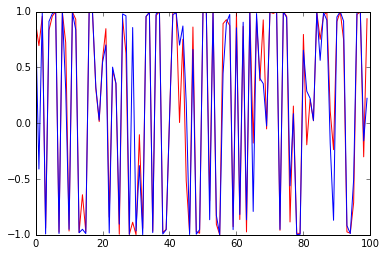

In [84]:
t = range(len(tester[0].flatten()))
plt.plot(t, tester[0].flatten(), 'r', t, tester[4].flatten(), 'b')
plt.show()

In [ ]:
#Three huge extension:
#    CHECK 1) give encoder to all decoding time steps
#    2) give predicted output to next time step as well
#    CHECK, but not tested 3) use bidirectional to use give beginning and end of encoder to decoder

#81 to 70
#normal 92 to 78 
#294.692